Some basic examples with the package. This is a rough continuum subtracted image (I haven't removed the skylines) of DG Tau taken in 2005 with the [OASIS](http://www.ing.iac.es/Astronomy/instruments/oasis/index.html) instrument on the William Herschel Telescope (I don't remember the project ID right now but when I find it I will update this). The PV-slice was generated using [`pvextractor`](https://github.com/keflavich/pvextractor) which is a super useful tool! The data file itself is in the `data` folder.

In [1]:
%load_ext autoreload
%autoreload 2

from telassar import PVSlice
from telassar.plotter import get_background_rms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
file = "../data/dgtau_OI6300_pvslice.fits"
pvdiag = PVSlice(file)

<IPython.core.display.Javascript object>


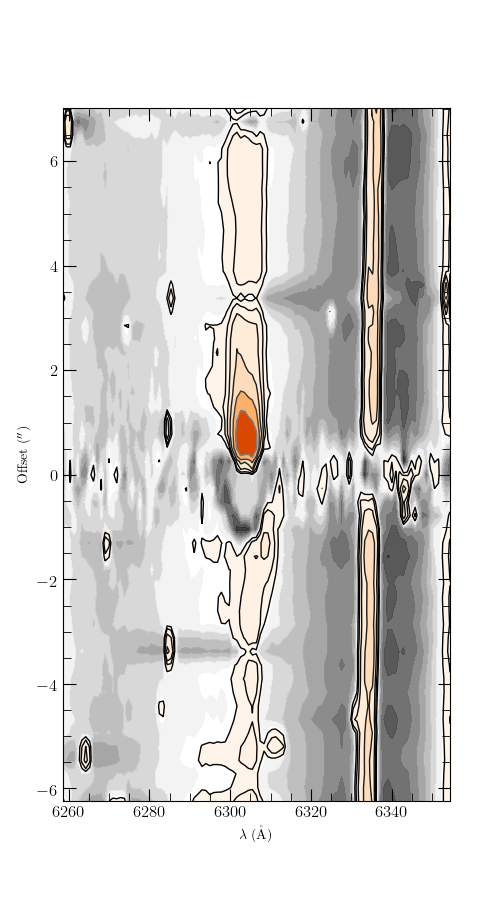

In [3]:
%matplotlib notebook

# make a simple plot
pvdiag.plot_contours(sigma=4)

Some customization can be done. We can trim the image to get a window around the [OI]$\lambda6300$ emission line with `spectral_window()`, then call the `radial_velocity()` method to get a rough estimate of the velocity ranges and format the graph accordingly. By default, `spectral_window()` assumes pixel units, so if we don't want that we can specify the units.

Additionally, if a systemic velocity is known for an object, you can specify the `vcorr` parameter in the `radial_velocity()` function. For DG Tau, we can correct for the systemic motion of the star with $v_{\rm Hel}$=16.5 km/s (Bacciotti et al., 2000, ApJ, 537, L49).

In [4]:
sub_pv = pvdiag.spectral_window(vmin=6291, vmax=6315, unit='angstrom')

lbda1, lbda2 = sub_pv.velwave.get_range()
vhel = 16.5

vrad = sub_pv.radial_velocity(ref='OI6300', lbdas=[lbda1, lbda2], vcorr=vhel)

Now, let's inspect it. With the `plot_contours()` method we can specify several parameters:

In [5]:
help(sub_pv.plot_contours)

Help on method plot_contours in module telassar.pvslice:

plot_contours(figure=None, place=None, sigma=None, mask=None, levels1=None, levels2=None, cmaps=None, fig_kws=None, plt_kws=None, emline=None) method of telassar.pvslice.PVSlice instance
    Generate a contour plot of the data. Useful for jet visualization!
    
    Parameters
    -----------
    figure : None or `matplotlib.Figure` instance
        if you have a figure instance you want to send this to, specify it
    sigma : None or float
        the basis for generating levels. a 3sigma value indicates detection
        of a source, we abbreviate it here to just sigma
    place : int
        if you have multiple subplot axes, you can send the image to one
    mask : `np.ma.masked_array`
        if you want to specify a mask to send when computing the background
        levels, do it here
    levels1 : None or `np.ndarray` or list
        the contour levels for the jets
    levels2 : None or `np.ndarray` or list
        the co

So there's an attempt here at making a fairly easily customizable plot. Anything not specified by the user will be estimated by the plotter. The standard contour levels honestly aren't the best, and I haven't figured out a good way to handle them. But, we can define our own, so let's pass a few keywords and try them out.

<IPython.core.display.Javascript object>


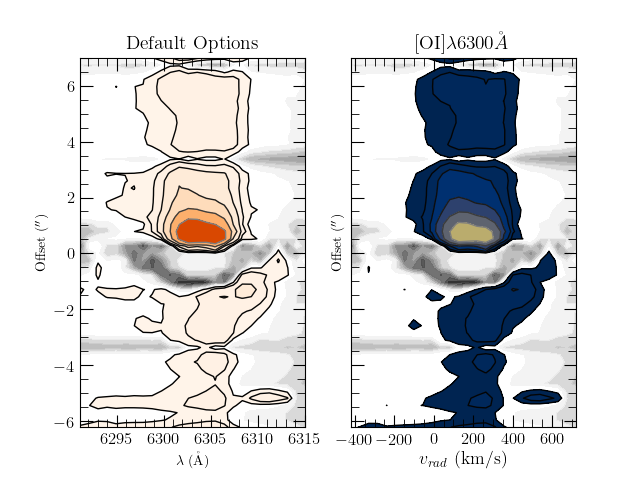

Text(0.5, 0, '$v_{rad}$ (km/s)')

In [6]:
%matplotlib notebook

fig, axes = plt.subplots(ncols=2, sharey=True)

# Just use default options
sub_pv.plot_contours(figure=fig, place=0, emline="Default Options") 

# customize it a bit
# calculate a background rms at a desired sigma value
sigma5 = get_background_rms(sub_pv.data, sigma=5.)

# set increasing levels in sqrt(2) increments
levels = [3*sigma5 * np.sqrt(2)**i for i in range(0, 13, 2)]
# print(levels)

# we can also define our own extent, using our radial velocity array
y1, y2 = sub_pv.position.get_range()
x1, x2 = vrad
extent = {'extent' : [x1, x2, y1, y2]}
sub_pv.plot_contours(figure=fig, 
                     place=1,
                     levels1=levels,
                     cmaps=['gist_gray', 'cividis', 'gray'],
                     plt_kws=extent,
                     emline="OI6300",
)

# just fix the x-axis label
axes[1].set_xlabel(r"$v_{rad}$ (km/s)", fontsize=13)

We can also take a cut across a spatial or spectral pixel (or pixels) to look at linear profiles, using either `spatial_profile()` or `spectral_profile()` class methods. If we plot this, it is interactive so we can click on a point to save it as a coordinate. This can be passed to the fitter and a profile can be plotted as well.

[INFO] Click on data points to save coordinates.


<IPython.core.display.Javascript object>


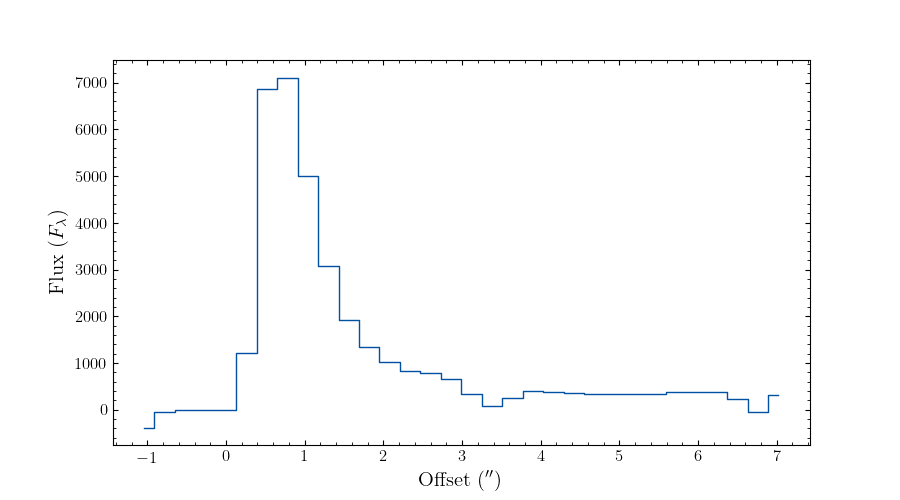

In [7]:
%matplotlib notebook

spatial_cut = sub_pv.spatial_profile(
    arc=[-1., sub_pv.position.get_stop()], 
    wave=[6303, 6305], 
    spat_unit=True, 
    spec_unit=True
)

spatial_cut.plot()

In this instance we have clicked a point on the peak, which is stored in the `spatial_cut` instance. The fitter is designed to be able to fit multiple peaks, so we can pass the model names as single-character keys, i.e. `g` for a Gaussian model, `l` for a Lorentzian model, or `v` for a Voigt profile. These are all passed to `lmfit`. This bit is a work in progress, so I will update it as I go!

[(0.5199999999999942, 6867.542188639939)]
We're running a test to send to `fitter.py`


<IPython.core.display.Javascript object>


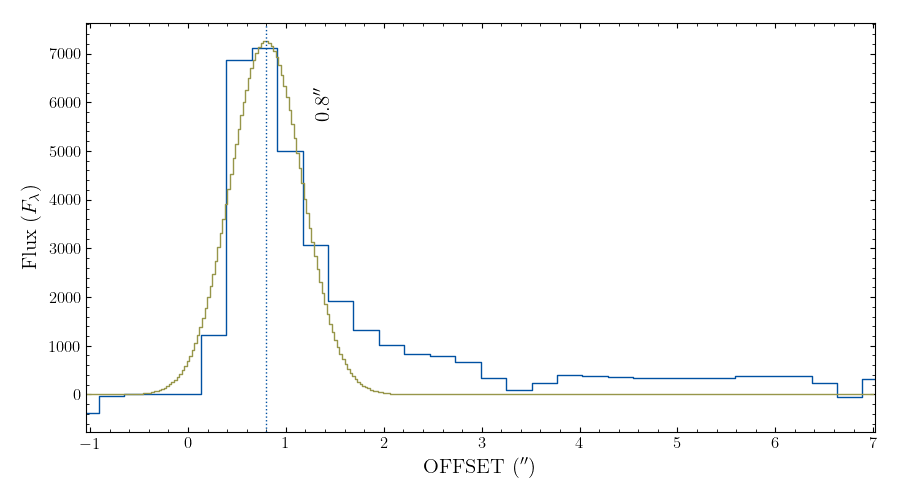

[[0.79757562]
 [0.8637038 ]
 [0.36678124]]


In [9]:
%matplotlib notebook

# what coord did we click?
print(spatial_cut._coords)

# let's fit a gaussian
model=['g']
spatial_cut.test_fitter(model)

The `test_fitter()` method just quickly plots it and spits out some fit information, which we see as the array below the plot. 